# Imports

In [264]:
import random
from   enum import Enum
from   pathlib import Path

%env CUDA_VISIBLE_DEVICES=1

import numpy as np
import seaborn as sns
import pandas as pd
import torch
import matplotlib.pyplot as plt
from   numba import njit
from   sklearn.decomposition import PCA
from   torch.utils.data import DataLoader
from   tqdm import tqdm, trange
from   umap import UMAP
from   pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from   datasets.functions_dataset import FunctionsDataset
from   datasets.utils.collate import Collater
from   utils.lightning_module import PlagiarismModel

env: CUDA_VISIBLE_DEVICES=1


In [265]:
@njit
def find_first(item, vec):
    """return the index of the first occurence of item in vec"""
    for i in range(len(vec)):
        if item == vec[i]:
            return i
    return -1

# STRUCTS

In [266]:
class Reduction(Enum):
    PCA  = "PCA"
    UMAP = "UMAP"

# CONSTANTS

In [267]:
NUM_VISUALIZE = 20
NUM_BASES     = 1096 # ALL

START     = 20

# TOP_K = 1096
# reduction = Reduction.PCA
reduction = Reduction.UMAP

In [268]:
if reduction == Reduction.PCA:
    REDUCER = PCA(2)
else:
    REDUCER = UMAP(30, min_dist=0.5, n_components=2, verbose=True)

In [278]:
def visualize_embeddings(embeddings, labels, bases):
    beg_idx = find_first(START, labels)
    vis_idx = find_first(START + NUM_VISUALIZE, labels)
    reduced_embeddings = REDUCER.fit_transform(embeddings[beg_idx:vis_idx])
    plt.figure(figsize=(10, 10))
    g = sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=bases[beg_idx:vis_idx], palette="gist_ncar")
    g.legend(loc='center left', bbox_to_anchor=(1.05, 0.7), ncol=1)

In [270]:
def compute_embeddings(model, loader):
    embeddings = []
    labels = []
    model.cuda().eval()
    with torch.no_grad():
        for batch in tqdm(loader, desc="Calculating embeddings..."):
            funs, bases, _ = batch
            embs = model.model(funs.cuda()).cpu().numpy()
            embeddings.append(embs)
            labels.extend(bases)

    embeddings = np.concatenate(embeddings)
    labels = np.array(labels)
    bases = np.array([dataset.function_bases[ind] for ind in labels])
    return embeddings, labels, bases

In [271]:
def map_r(encoder_embs, classifier_embs, labels, k = 10, num_functions=[10, 20, 50, 100, 500]):
    acc_calculator = AccuracyCalculator(include=("mean_average_precision_at_r",), device=torch.device("cpu"))
    num_all = len(np.unique(labels))
    res = []
    for num in num_functions:
        for i in trange(k, desc=f"# FUNCTIONS: {num}"):
            chosen_labels = random.choices(list(range(num_all)), k=num)
            mask  = np.isin(labels, chosen_labels)
            encoder_mapr = acc_calculator.get_accuracy(encoder_embs[mask], encoder_embs[mask], labels[mask], labels[mask],
                                    embeddings_come_from_same_source=True)["mean_average_precision_at_r"]
            
            res.append({
                "mapr": encoder_mapr,
                "num_fun": num,
                "k": i,
                "method": "encoder"
            })
            
            classifier_mapr = acc_calculator.get_accuracy(classifier_embs[mask], classifier_embs[mask], labels[mask], labels[mask],
                                    embeddings_come_from_same_source=True)["mean_average_precision_at_r"]
            
            res.append({
                "mapr": classifier_mapr,
                "num_fun": num,
                "k": i,
                "method": "classifier"
            })
    return pd.DataFrame(res)

# GRAPHS

In [272]:
format_str = "graph"
data_root = Path("data/graph_functions")
batch_size = 512
classifier_path = "lightning_logs/version_472/checkpoints/epoch=10-step=1836.ckpt"
encoder_path    = "lightning_logs/version_460/checkpoints/epoch=34-step=5704.ckpt"

In [244]:
split_file = data_root / "test.txt"
mode = "singles"
cache_dir = "data/cache"

with split_file.open() as f:
    bases = [l.strip() for l in f]
bases_counts = {base: len(list((data_root / base).iterdir())) for base in bases}
sampled_bases = list(reversed(sorted(bases_counts.items(), key=lambda item: item[1])))
sampled_bases = [item[0] for item in sampled_bases]

dataset = FunctionsDataset(str(data_root), sampled_bases, mode, format_str, cache=cache_dir)
dataloader = DataLoader(dataset, batch_size, num_workers=10, collate_fn=Collater(), pin_memory=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1096/1096 [00:00<00:00, 88062.63it/s]


In [245]:
classifier = PlagiarismModel.load_from_checkpoint(classifier_path)
classifier_embeddings, labels, bases = compute_embeddings(classifier, dataloader)

Calculating embeddings...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [01:00<00:00,  1.57it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.5, n_neighbors=30, verbose=True)
Construct fuzzy simplicial set
Sun Jan 30 12:17:29 2022 Finding Nearest Neighbors
Sun Jan 30 12:17:29 2022 Finished Nearest Neighbor Search
Sun Jan 30 12:17:30 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Jan 30 12:18:13 2022 Finished embedding


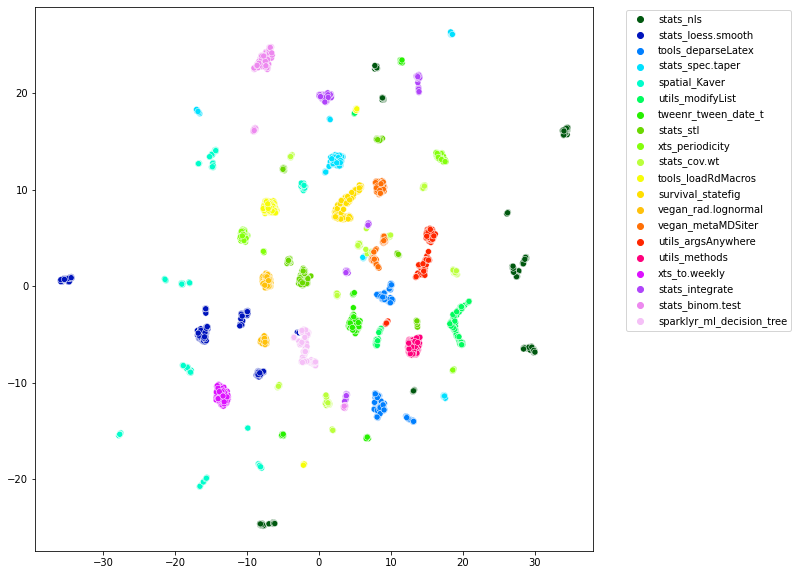

In [279]:
visualize_embeddings(classifier_embeddings, labels, bases)

In [247]:
encoder = PlagiarismModel.load_from_checkpoint(encoder_path)
encoder_embeddings, _, _ = compute_embeddings(encoder, dataloader)

Calculating embeddings...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:17<00:00,  5.49it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.5, n_neighbors=30, verbose=True)
Construct fuzzy simplicial set
Sun Jan 30 12:18:49 2022 Finding Nearest Neighbors
Sun Jan 30 12:18:49 2022 Finished Nearest Neighbor Search
Sun Jan 30 12:18:49 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Jan 30 12:19:12 2022 Finished embedding


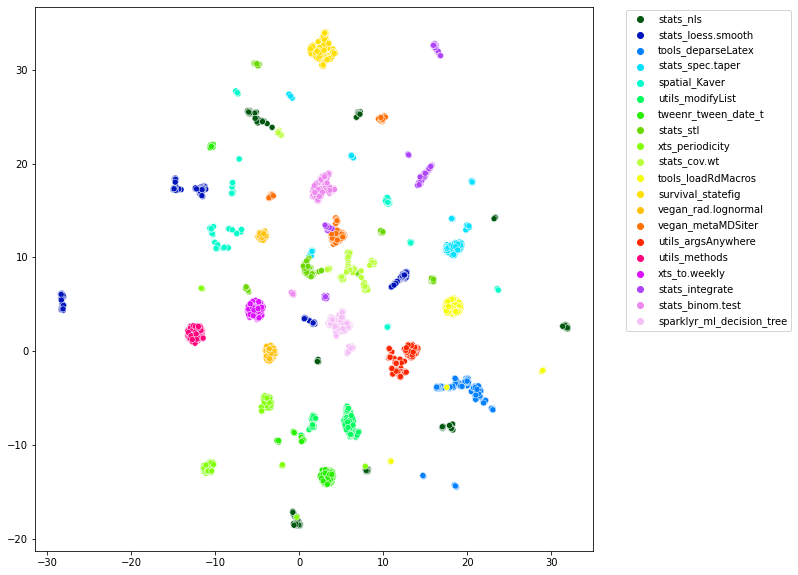

In [280]:
visualize_embeddings(encoder_embeddings, labels, bases)

In [281]:
mapr_graphs = map_r(encoder_embeddings, classifier_embeddings, labels)
mapr_graphs

# FUNCTIONS: 500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:49<00:00, 58.99s/it]


,mapr,num_fun,k,method
0,0.904387,10,0,encoder
1,0.960284,10,0,classifier
2,0.975501,10,1,encoder
3,0.946323,10,1,classifier
4,0.825070,10,2,encoder
...,...,...,...,...
95,0.714805,500,7,classifier
96,0.591297,500,8,encoder
97,0.653998,500,8,classifier
98,0.514914,500,9,encoder


In [286]:
mapr_graphs.groupby(["method", "num_fun"], as_index=False).mapr.agg({"mean": "mean", "std": "std"})

,method,num_fun,mean,std
0,classifier,10,0.927227,0.062314
1,classifier,20,0.890974,0.070029
2,classifier,50,0.784815,0.078035
3,classifier,100,0.779059,0.073495
4,classifier,500,0.671259,0.055980
5,encoder,10,0.898303,0.046721
6,encoder,20,0.867233,0.088156
7,encoder,50,0.744320,0.079216
8,encoder,100,0.720479,0.080836
9,encoder,500,0.607311,0.054122


# TOKENS

In [287]:
format_str = "tokens"
data_root = Path("data/functions")
batch_size = 200
classifier_path = "lightning_logs/version_502/checkpoints/epoch=17-step=17999.ckpt"
encoder_path    = "lightning_logs/version_499/checkpoints/epoch=24-step=24324.ckpt"

In [288]:
dataset = FunctionsDataset(str(data_root), sampled_bases, mode, format_str, cache=cache_dir)
dataloader = DataLoader(dataset, batch_size, num_workers=10, collate_fn=Collater(), pin_memory=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1096/1096 [00:00<00:00, 93553.88it/s]


In [291]:
classifier = PlagiarismModel.load_from_checkpoint(classifier_path)
classifier_embeddings, labels, bases = compute_embeddings(classifier, dataloader)

Calculating embeddings...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [02:12<00:00,  1.84it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.5, n_neighbors=30, verbose=True)
Construct fuzzy simplicial set
Sun Jan 30 14:50:39 2022 Finding Nearest Neighbors
Sun Jan 30 14:50:39 2022 Finished Nearest Neighbor Search
Sun Jan 30 14:50:39 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Jan 30 14:50:46 2022 Finished embedding


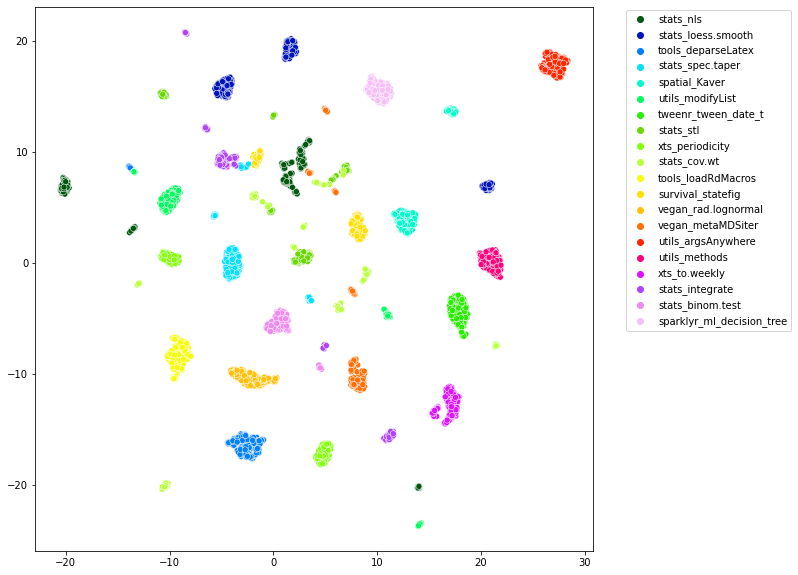

In [292]:
visualize_embeddings(classifier_embeddings, labels, bases)

In [297]:
encoder = PlagiarismModel.load_from_checkpoint(encoder_path)
encoder_embeddings, _, _ = compute_embeddings(encoder, dataloader)

Calculating embeddings...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [01:55<00:00,  2.11it/s]


UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.5, n_neighbors=30, verbose=True)
Construct fuzzy simplicial set
Sun Jan 30 15:18:02 2022 Finding Nearest Neighbors
Sun Jan 30 15:18:02 2022 Finished Nearest Neighbor Search
Sun Jan 30 15:18:02 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Jan 30 15:18:10 2022 Finished embedding


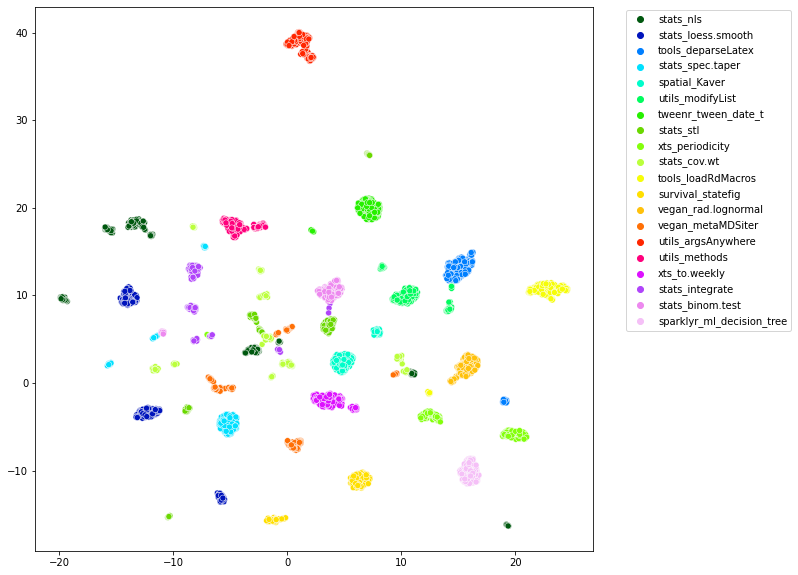

In [298]:
visualize_embeddings(encoder_embeddings, labels, bases)

In [299]:
mapr_tokens = map_r(encoder_embeddings, classifier_embeddings, labels)
mapr_tokens

# FUNCTIONS: 500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:15<00:00, 55.51s/it]


,mapr,num_fun,k,method
0,0.901310,10,0,encoder
1,0.965656,10,0,classifier
2,1.000000,10,1,encoder
3,1.000000,10,1,classifier
4,0.858080,10,2,encoder
...,...,...,...,...
95,0.702107,500,7,classifier
96,0.727269,500,8,encoder
97,0.736882,500,8,classifier
98,0.647185,500,9,encoder


In [300]:
mapr_tokens.groupby(["method", "num_fun"], as_index=False).mapr.agg({"mean": "mean", "std": "std"})

,method,num_fun,mean,std
0,classifier,10,0.972165,0.034884
1,classifier,20,0.902831,0.090187
2,classifier,50,0.835591,0.068407
3,classifier,100,0.728167,0.086996
4,classifier,500,0.652017,0.057972
5,encoder,10,0.955000,0.045544
6,encoder,20,0.895144,0.082282
7,encoder,50,0.814627,0.076726
8,encoder,100,0.711199,0.091658
9,encoder,500,0.641064,0.059254


In [302]:
mapr_tokens["modality"] = "tokens"
mapr_graphs["modality"] = "graphs"
mapr_all = pd.concat([mapr_tokens, mapr_graphs])

In [308]:
from scipy.stats import wilcoxon

def max_wilcoxon_mask(df, param):
    statistical_max = []
    for modality, modality_group in df.groupby("modality"):
        for param_val, param_group in modality_group.groupby(param):
            best_group = None
            best_median = 0
            best_method = None
            for method, method_group in param_group.groupby("method"):
                if method_group["mapr"].median() > best_median:
                    best_median = method_group["mapr"].median()
                    best_group = method_group
                    best_method = method
            for method, method_group in param_group.groupby("method"):
                if best_method != method:
                    test_res = wilcoxon(best_group["mapr"], method_group["mapr"])
                    alpha = 0.05
                    if test_res[1] < alpha:
                        stat_max = False
                    else:
                        stat_max = True
                else:
                    stat_max = True
                statistical_max.append({
                    param: param_val,
                    "modality": modality,
                    "method": method,
                    "stat_max": stat_max
                })
    return pd.DataFrame(statistical_max)

In [317]:
median_maprs = mapr_all.groupby(["modality", "method", "num_fun"], as_index=False).mapr.agg({"median": "median", "std": "std"})

In [318]:
max_mask = max_wilcoxon_mask(mapr_all, "num_fun")

/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [319]:
median_maprs = median_maprs.merge(max_mask, on=["num_fun", "modality", "method"])
median_maprs

,modality,method,num_fun,median,std,stat_max
0,graphs,classifier,10,0.946094,0.062314,True
1,graphs,classifier,20,0.903871,0.070029,True
2,graphs,classifier,50,0.793673,0.078035,True
3,graphs,classifier,100,0.785392,0.073495,True
4,graphs,classifier,500,0.671082,0.055980,True
5,graphs,encoder,10,0.901919,0.046721,False
6,graphs,encoder,20,0.876885,0.088156,True
7,graphs,encoder,50,0.747043,0.079216,False
8,graphs,encoder,100,0.726118,0.080836,False
9,graphs,encoder,500,0.605109,0.054122,False


In [320]:
median_maprs["mapr"] = median_maprs["median"].map("{:.3f}".format) + " ± " + median_maprs["std"].map("{:.3f}".format)
def format_str(row):
    if row["stat_max"]:
        return r"\textbf{" + row["mapr"] + "}"
    return row["mapr"]
median_maprs["mapr"] = median_maprs.apply(format_str, axis="columns")
pivot_table = median_maprs.pivot(index="num_fun", columns=["modality","method"], values="mapr")

In [322]:
print(pivot_table.to_latex(escape=False))

\begin{tabular}{lllll}
\toprule
modality & \multicolumn{2}{l}{graphs} & \multicolumn{2}{l}{tokens} \\
method &              classifier &                 encoder &              classifier &                 encoder \\
num_fun &                         &                         &                         &                         \\
\midrule
10      &  \textbf{0.946 ± 0.062} &           0.902 ± 0.047 &  \textbf{0.984 ± 0.035} &           0.963 ± 0.046 \\
20      &  \textbf{0.904 ± 0.070} &  \textbf{0.877 ± 0.088} &  \textbf{0.935 ± 0.090} &  \textbf{0.930 ± 0.082} \\
50      &  \textbf{0.794 ± 0.078} &           0.747 ± 0.079 &  \textbf{0.845 ± 0.068} &           0.801 ± 0.077 \\
100     &  \textbf{0.785 ± 0.073} &           0.726 ± 0.081 &  \textbf{0.714 ± 0.087} &           0.698 ± 0.092 \\
500     &  \textbf{0.671 ± 0.056} &           0.605 ± 0.054 &  \textbf{0.663 ± 0.058} &           0.652 ± 0.059 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_463171/1180236412.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pivot_table.to_latex(escape=False))
